In [14]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
import sys
import torch 
sys.path.insert(0,'../src/')
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [31]:
import datap_efficient_runs as drun
import model_train_benchmark as trb
from labeling_system import *
import cvt_OHE_full_att as cvt

from datap_efficient_bench import *
import model_train_benchmark as trb
from labeling_system import *
import cvt_benchmark_attn as cvtb

In [18]:
# Set up your font properties (optional)
font = fm.FontProperties()
font.set_family('serif')
font.set_name('DejaVu Sans Mono')  # Times font
sns.set(font="DejaVu Sans Mono")

%matplotlib inline 

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
testo = np.load("../output/testoo.npy", allow_pickle=True)
valido = np.load("../output/validoo.npy", allow_pickle=True)
traino = np.load("../output/trainoo.npy", allow_pickle=True)

In [9]:
main_runs = pd.read_csv('../input/main_runs.csv')
# ------

soft_label_dict_run1 = create_label_dict1(main_runs)
soft_label_dict_run2 = create_label_dict2(main_runs)

soft_run1_conf, soft_run1_spur = section_spurious(soft_label_dict_run1, num=3)
soft_run2_conf, soft_run2_spur = section_spurious(soft_label_dict_run2, num=7)

hard_run1_conf = create_hard_labels(soft_run1_conf)
hard_run2_conf = create_hard_labels(soft_run2_conf)

print(Counter(list(hard_run1_conf.values())))
print(Counter(list(hard_run2_conf.values())))

imgs_path = '../input/images_gz2/images/'
W, H, C = 224, 224, 4

conf_file_list = create_file_list(imgs_path, soft_run1_conf, soft_run2_conf)

n = 5000
bs = 64
embed_size = 64
device= 'cuda' if torch.cuda.is_available() else 'cpu'

Counter({0: 130557, 1: 56602, 2: 17603})
Counter({1: 69767, 0: 58485, 4: 51702, 5: 14903, 3: 13821, 2: 9566, 6: 6043})


---

In [10]:
train_dl_run1, valid_dl_run1, test_dl_run1, train_coarse1, valid_coarse1, test_coarse1 = drun.create_dali_iterators(traino, valido, testo, hard_run1_conf, bs)

In [13]:
torch.cuda.empty_cache()
gc.collect()

500

In [15]:
import model_train_benchmark as trb

In [16]:
model_path = '../output/run1_02/model_RUN_01_full_final_02_epoch32.pth'
gmorph_model1 = cvt.CvT_cyclic(embed_size, 3, hint=False)
state_dict = torch.load(model_path)      

# Convert all parameters to half precision and move to device
for key in state_dict:
    if state_dict[key].dtype == torch.float32:
        state_dict[key] = state_dict[key].half()
    state_dict[key] = state_dict[key].to(device)
        
gmorph_model1.load_state_dict(state_dict)         
gmorph_model1 = gmorph_model1.half().to(device)  # Ensure model is in half precision and on device
gmorph_model1.eval()  

y_true1, y_preds1, out1, galaxy_ids1 = trb.test_model(test_dl_run1, gmorph_model1, device)

torch.cuda.empty_cache()
gc.collect()

552

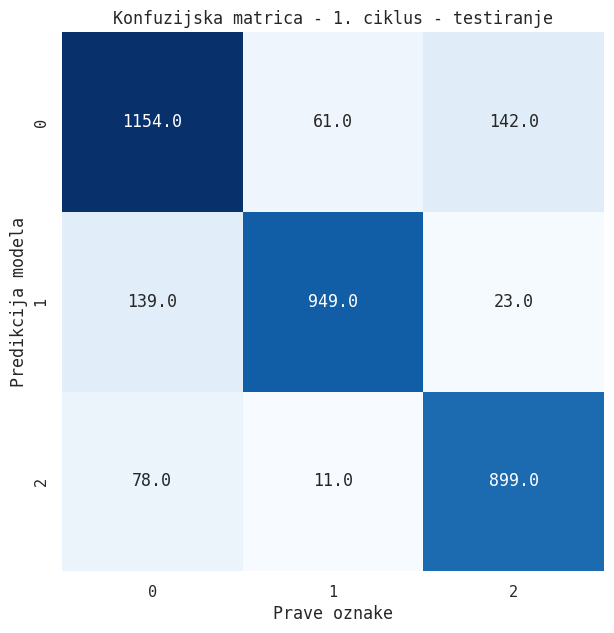

In [19]:
ct = pd.crosstab(y_preds1,  y_true1, rownames=["Predikcija modela"], colnames=["Prave oznake"])
plt.figure(figsize=(7,7))
sns.heatmap(ct, cmap="Blues", annot=True, xticklabels="012", yticklabels="012", fmt=".1f", cbar=False)
plt.title("Konfuzijska matrica - 1. ciklus - testiranje",fontproperties=font, fontsize=12)
plt.savefig('../images/confusion_matrix_run1_test.png',dpi=300, bbox_inches = 'tight')

plt.show()

In [20]:
torch.cuda.empty_cache()
gc.collect()

5863

In [21]:
out_array1 = np.array(out1)

max_probs1 = (np.max(out_array1, axis=1), np.argmax(out_array1, axis=1))

bench_test1 = pd.DataFrame()
bench_test1['Vjerojatnost'] = max_probs1[0]
bench_test1['Predikcija'] = max_probs1[1]
bench_test1['Oznaka'] = y_true1
bench_test1['ID'] = galaxy_ids1

bench_test1['Correct'] = np.where(bench_test1['Predikcija'] == bench_test1['Oznaka'], 1, 0)

print((sum(bench_test1['Correct'])/bench_test1.shape[0])*100)

86.86342592592592


In [22]:
bench_test1.head()

,Vjerojatnost,Predikcija,Oznaka,ID,Correct
0,0.867902,2,2.0,129469,1
1,0.989254,1,1.0,119388,1
2,0.988462,1,1.0,284459,1
3,0.944766,1,1.0,153665,1
4,0.971528,0,0.0,40401,1


In [23]:
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
train_dl_run2, valid_dl_run2, test_dl_run2, train_coarse2, valid_coarse2, test_coarse2 = drun.create_dali_iterators(traino, valido, testo, hard_run2_conf, bs, previous=train_coarse1)

In [25]:
torch.cuda.empty_cache()
gc.collect()

0

In [26]:
model_path = '../output/run2_02/model_RUN_02_full_final_02_epoch32.pth'
gmorph_model2 = cvt.CvT_cyclic(embed_size, 7, hint=True)
state_dict = torch.load(model_path)      

# Convert all parameters to half precision and move to device
for key in state_dict:
    if state_dict[key].dtype == torch.float32:
        state_dict[key] = state_dict[key].half()
    state_dict[key] = state_dict[key].to(device)
        
gmorph_model2.load_state_dict(state_dict)         
gmorph_model2 = gmorph_model2.half().to(device)  # Ensure model is in half precision and on device
gmorph_model2.eval()  

y_true2, y_preds2, out2, galaxy_ids2 = trb.test_model(test_dl_run2, gmorph_model2, device)

torch.cuda.empty_cache()
gc.collect()

237

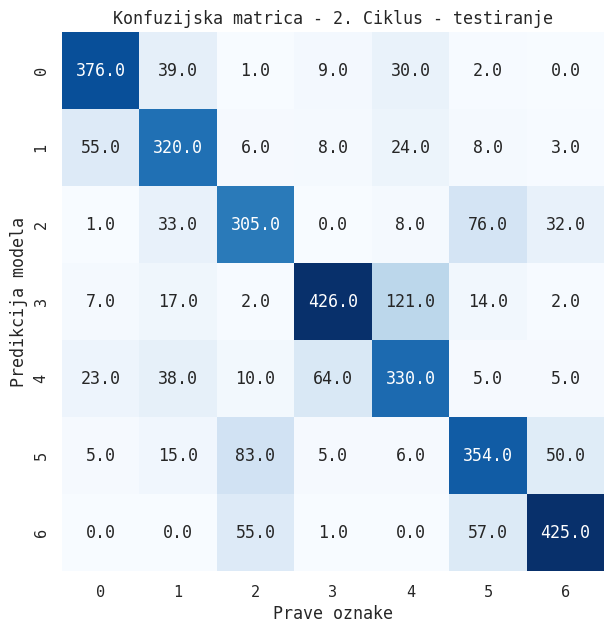

In [27]:
ct = pd.crosstab(y_preds2,  y_true2, rownames=["Predikcija modela"], colnames=["Prave oznake"])
plt.figure(figsize=(7,7))
sns.heatmap(ct, cmap="Blues", annot=True, xticklabels="0123456", yticklabels="0123456", fmt=".1f", cbar=False)
plt.title("Konfuzijska matrica - 2. Ciklus - testiranje",fontproperties=font, fontsize=12)
plt.savefig('../images/confusion_matrix_run2_test.png',dpi=300, bbox_inches = 'tight')

plt.show()

In [28]:
out_array2 = np.array(out2)

max_probs2 = (np.max(out_array2, axis=1), np.argmax(out_array2, axis=1))

bench_test2 = pd.DataFrame()
bench_test2['Vjerojatnost'] = max_probs2[0]
bench_test2['Predikcija'] = max_probs2[1]
bench_test2['Oznaka'] = y_true2
bench_test2['ID'] = galaxy_ids2

bench_test2['Correct'] = np.where(bench_test2['Predikcija'] == bench_test2['Oznaka'], 1, 0)

print((sum(bench_test2['Correct'])/bench_test2.shape[0])*100)

73.37962962962963


In [30]:
bench_test1.to_csv("../output/bench_test_run1.csv", index=False)
bench_test2.to_csv("../output/bench_test_run2.csv", index=False)
